In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
def vis_cliff_walking(qtable, ax, norm=False):
    q3d = qtable.reshape(4, 12, 4)
    
    maxq2d = np.max(q3d, axis=2)
    maxq = np.max(maxq2d)
    minq = np.min(maxq2d)
    q_range = maxq-minq
    ax.imshow(maxq2d)

    for r in range(4):
        for c in range(12):

            q4 = q3d[r, c, :]
            besta = np.argmax(q4)

            if besta == 0: # 0: Move up
                vec = np.array([0, -1])
            elif besta == 1:
                vec = np.array([1, 0])            
            elif besta == 2:
                vec = np.array([0, 1])
            elif besta == 3:
                vec = np.array([-1, 0])
            else:
                raise
            
            if norm:

                vec = ( (vec * (q4[besta] - minq)) / q_range) * 0.5
            else:
                vec = vec * 0.25
            ax.arrow(c, r, vec[0], vec[1], head_width=0.2)

In [24]:
class Agent():
    def __init__(self, obs_dim, act_dim, epsilon=0.2, policy='epsilon-greedy', policy_mat=None):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.max_dim = obs_dim * act_dim
        self.epsilon = epsilon
        self.policy = policy
        self.policy_mat = policy_mat
        if self.policy == 'custom':
            assert self.policy_mat is not None

        self.qtable = np.random.normal(0, 0.0001, size=(self.obs_dim, self.act_dim))
        self.ztable = np.zeros((obs_dim, act_dim))

    def a_epsilon_greedy(self, s):
        q_alla = self.qtable[s, :]
        if np.random.rand() < self.epsilon:
            out_a = np.random.choice(self.act_dim)
        else:
            out_a = np.argmax(q_alla)
        return out_a, q_alla
    
    def a_custom(self, s):
        return self.policy_mat[s], self.qtable[s, :]
    
    def select_action(self, s):
        if self.policy == 'epsilon-greedy':
            return self.a_epsilon_greedy(s)
        elif self.policy == 'custom':
            return self.a_custom(s)
    




# SARSA(1)

In [9]:
def sarsa1(ag, env, gamma, alpha):
    t = 0
    terminated = False
    s, _ = env.reset()
    while (terminated is False) :
        a, q_alla_now = ag.select_action(s)
        q_now = q_alla_now[a]
        s_next, r_next, terminated, _, _ = env.step(a)
        a_next, all_q_next = ag.select_action(s_next)
        q_next = all_q_next[a_next]
        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now
        ag.qtable[s, a] += alpha * td_err
        s = s_next
        t += 1
    return t

episode 0, t=0
episode 1000, t=40
episode 2000, t=34
episode 3000, t=17
episode 4000, t=18


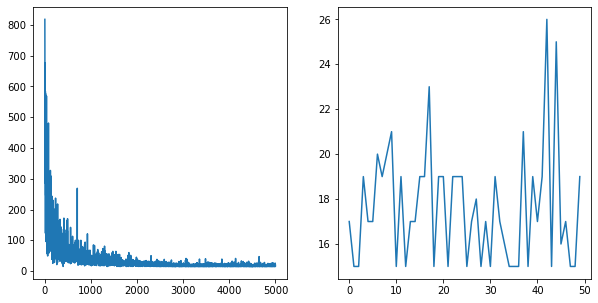

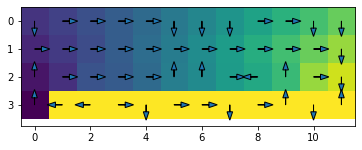

In [10]:
env = gym.make('CliffWalking-v0')
obs_dim = 48
act_dim = 4
ag = Agent(obs_dim, act_dim, epsilon=0.1)
gamma = 0.98
alpha = 0.01

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = sarsa1(ag, env, gamma, alpha)
    all_ts[ni] = t

env.close()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[-50:])
fig, ax = plt.subplots()
vis_cliff_walking(ag.qtable, ax)


# Sarsa(n)

In [16]:
def sarsaN(ag, env, gamma, alpha, Nstep):
    terminated = False
    s, _ = env.reset()
    
    allR_ep = []
    allS_ep = []
    allA_ep = []
    allQ_ep = []
    t = 0
    tau = t - Nstep + 1
    
    while (terminated is False) or (tau < t):
        
        if terminated is False:
            a, q_alla_now = ag.select_action(s)
            q_now = q_alla_now[a]
            s_next, r_next, terminated, _, _ = env.step(a)
            a_next, all_q_next = ag.select_action(s_next)
            q_next = all_q_next[a_next]

            if terminated:
                q_next = 0

            allR_ep.append(r_next)
            allS_ep.append(s)
            allA_ep.append(a)
            allQ_ep.append(q_now)
        else:
            q_next = 0  # if terminated, freeze q_next as terminal return = 0

        
        if terminated is False:
            tau = t - Nstep + 1
        else:
            tau += 1  # If terminated, tau keeps being incremented until T-1
        
        if tau >=0:
            V = 0
            max_tau = min(tau+Nstep, t+1)
            for j in range(tau, max_tau):
                V += allR_ep[j] * (gamma**(j-tau))
            V += (gamma ** (j-tau + 1)) * q_next
        

            td_err = V - allQ_ep[tau]
            ag.qtable[allS_ep[tau], allA_ep[tau]] += alpha * td_err
        
        
        s = s_next

        if terminated is False:
            t += 1  # Freeze t as terminal time T
    return t

episode 0, t=0
episode 1000, t=16
episode 2000, t=16
episode 3000, t=17
episode 4000, t=16


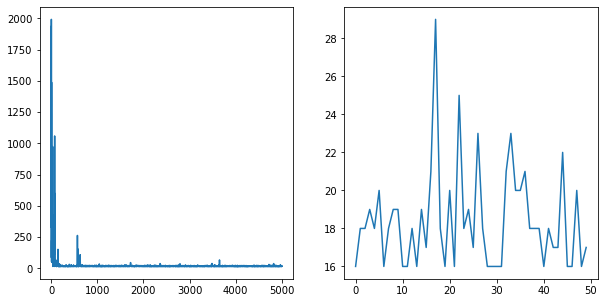

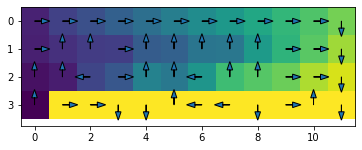

In [19]:
env = gym.make('CliffWalking-v0')
obs_dim = 48
act_dim = 4

gamma = 0.98
alpha = 0.01
Nstep = 10
ag = Agent(obs_dim, act_dim, epsilon=0.1)
Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = sarsaN(ag, env, gamma, alpha, Nstep)
    all_ts[ni] = t


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[-50:])
fig, ax = plt.subplots()
vis_cliff_walking(ag.qtable, ax)


# Sarsa($\lambda$)

In [21]:
def sarsaLamb(ag, env, gamma, alpha, lamb):
    t = 0
    terminated = False
    s, _ = env.reset()
    while (terminated is False) :
        a, q_alla_now = ag.select_action(s)
        ag.ztable[s, a] += 1
        q_now = q_alla_now[a]
        s_next, r_next, terminated, _, _ = env.step(a)
        a_next, all_q_next = ag.select_action(s_next)
        q_next = all_q_next[a_next]
        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now
        ag.qtable[s, a] += alpha * td_err * ag.ztable[s, a]
        ag.ztable = gamma * lamb * ag.ztable
        s = s_next
        t += 1
    return t

episode 0, t=0
episode 1000, t=51
episode 2000, t=15
episode 3000, t=17
episode 4000, t=17


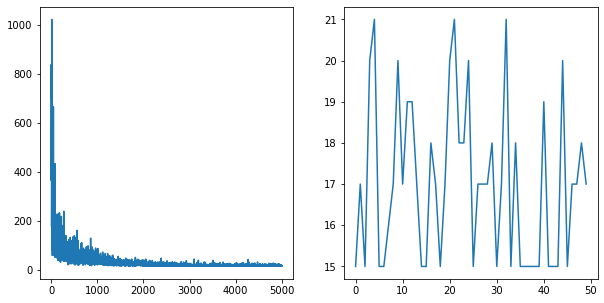

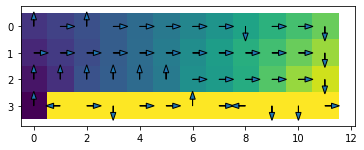

In [23]:
env = gym.make('CliffWalking-v0')
obs_dim = 48
act_dim = 4
gamma = 0.98
lamb = 0.8
alpha = 0.01
epsilon = 0.1
ag = Agent(obs_dim, act_dim, epsilon=epsilon)

ztable = np.zeros((obs_dim, act_dim))

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = sarsaLamb(ag, env, gamma, alpha, lamb)

    all_ts[ni] = t

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[-50:])
fig, ax = plt.subplots()
vis_cliff_walking(ag.qtable, ax)


# Compare

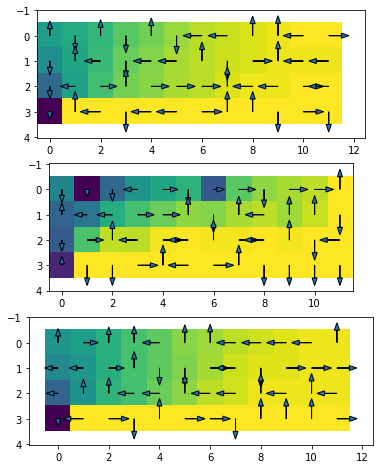

In [31]:

fig, ax = plt.subplots(3, 1, figsize=(10, 8))

vis_cliff_walking(q_sarsa1, ax[0], norm=True)
vis_cliff_walking(q_sarsa10, ax[1], norm=True)
vis_cliff_walking(q_sarsaLamb, ax[2], norm=True)

